In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.constants import c

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Integrated dispersion

/content/drive/MyDrive/Integrated dispersion


In [4]:
# plot settings

import matplotlib as mpl

mpl.rcParams.update({
    # --- Fonts ---
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],  # Arial first, fallback if missing
    "font.size": 14,               # base size for EVERYTHING
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,

    # --- Spines & ticks ---
    "axes.linewidth": 3,           # spine width
    "xtick.major.width": 3,
    "ytick.major.width": 3,
    "xtick.minor.width": 3,
    "ytick.minor.width": 3,
    "xtick.major.size": 6,         # tick length
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
})

mpl.rcParams.update({
    "mathtext.fontset": "custom",
    "mathtext.rm": "Arial",
    "mathtext.it": "Arial:italic",
    "mathtext.bf": "Arial:bold",
})

In [5]:
# Load the file
filename = "Dispersion_with_cladding_1200x800nm.txt"

# Skip the first two lines (headers), then load the rest
data = np.loadtxt(filename, delimiter=',', skiprows=3)

wavelength = data[:, 0] # In um
frequency = 299792.458/wavelength # In ghz
dispersion = data[:, 1]   # In ps/nm/km

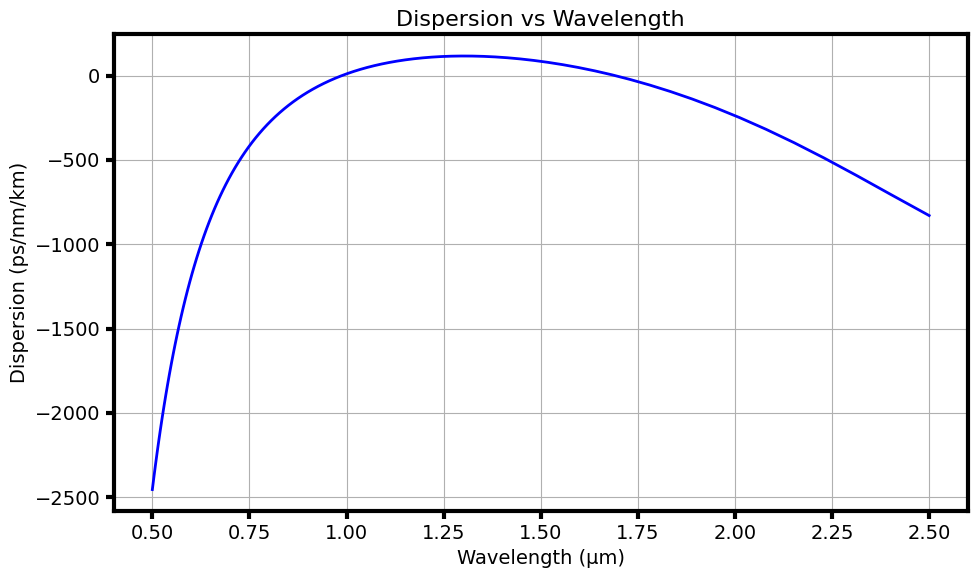

In [6]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(wavelength, dispersion, color='blue', linewidth=2)
plt.grid(True)
plt.xlabel('Wavelength (µm)', fontsize=14)
plt.ylabel('Dispersion (ps/nm/km)', fontsize=14)
plt.title('Dispersion vs Wavelength', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
def integrated_dispersion(wavelength_um, dispersion_ps_nm_km, pump_wavelength_um, radius_um, fsr_ghz):
    """
    Calculate integrated dispersion (D_int) in GHz.

    Parameters:
    - wavelength_um: np.ndarray, wavelength vector in μm
    - dispersion_ps_nm_km: np.ndarray, dispersion vector in ps/nm/km
    - pump_wavelength_um: float, pump wavelength in μm

    Returns:
    - mode_numbers: np.ndarray, relative mode indices (μ)
    - D_int_GHz: np.ndarray, integrated dispersion in GHz

    Formulas from https://arxiv.org/pdf/2001.00650
    """

    # Convert units
    wavelength_m = wavelength_um * 1e-6
    freq_Hz = c / wavelength_m  # in Hz
    freq_GHz = freq_Hz * 1e-9

    # Sort by increasing frequency
    sort_idx = np.argsort(freq_GHz)
    freq_GHz = freq_GHz[sort_idx]
    dispersion_ps_nm_km = dispersion_ps_nm_km[sort_idx]
    wavelength_um = wavelength_um[sort_idx]

    R = radius_um * 1e-6
    D1 = fsr_ghz * 1e9
    beta1 = 1 / (R * D1)

    # Convert dispersion D(λ) [ps/nm/km] to β2 [s^2/m]
    beta2 = -(wavelength_um * 1e-6)**2 / (2 * np.pi * c) * dispersion_ps_nm_km * 1e-12 / 1e-9
    D2 = - beta2 / (beta1**3 * R**2)

    beta3 = np.gradient(beta2, freq_GHz) * 1e-9
    beta4 = np.gradient(beta3, freq_GHz) * 1e-9

    D3 = - beta3 / (R**3 * beta1**4) + 3 * beta2**2 / (R**3 * beta1**5)
    D4 = - beta4 / (R**4 * beta1**5) - 33 * beta2**3 / (R**4 * beta1**7) + 16 * beta2 * beta3 / (R**4 * beta1**6)

    # Numerically integrate group delay to get frequency vs mode
    df = np.gradient(freq_GHz)  # GHz
    dphi = np.cumsum(beta2 * df * 1e9)  # rough integral in rad

    # Define pump frequency
    f0 = c / (pump_wavelength_um * 1e-6) * 1e-9  # in GHz

    # Mode numbers (relative)
    mu = np.round((freq_GHz - f0) / np.mean(np.diff(freq_GHz))).astype(int)

    D_int = D2*mu**2/2 + D3*mu**3/6 + D4*mu**4/24
    D_int_GHz = D_int * 1e-9

    return [mu, wavelength_um, freq_GHz, D_int_GHz, D2, D3, D4]

In [8]:
pump_wl_um = 1.55
fsr_ghz = 772
R = ((2 * np.pi * 20 * 1.1) + (4 * 12)) / (2 * np.pi)

out = integrated_dispersion(wavelength, dispersion, pump_wl_um, R, fsr_ghz)

mu = out[0]
wl = out[1]
freq_ghz = out[2]
D_int = out[3]

D2 = out[4]
D3 = out[5]
D4 = out[6]

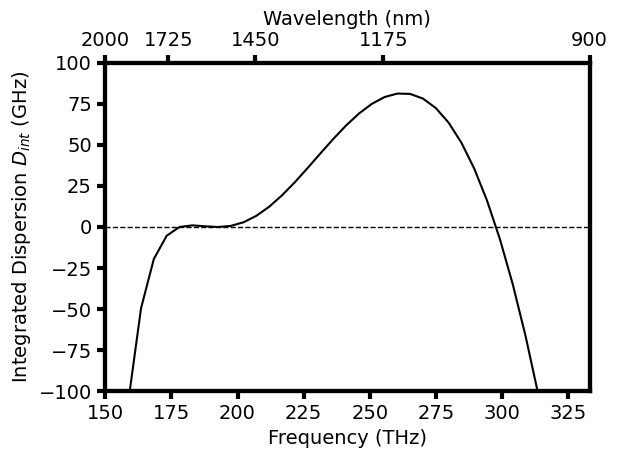

In [9]:
wl_min_nm = 900
wl_max_nm = 2000

# === Convert to frequency range in THz ===
freq_min_thz = c * 1e-3 / wl_max_nm  # higher wavelength → lower freq
freq_max_thz = c * 1e-3 / wl_min_nm  # lower wavelength → higher freq

# === Plot ===
fig, ax1 = plt.subplots()

# Bottom x-axis: Frequency (THz)
ax1.plot(freq_ghz / 1000, D_int, 'k-')
ax1.set_xlabel("Frequency (THz)")
ax1.set_ylabel("Integrated Dispersion $D_{int}$ (GHz)")
ax1.set_xlim(freq_min_thz, freq_max_thz)
ax1.set_ylim(- 100, 100)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

# === Top x-axis: Wavelength (nm) ===
ax2 = ax1.twiny()

# Create wavelength ticks and convert to THz
wl_ticks_nm = np.linspace(wl_min_nm, wl_max_nm, 5)
freq_ticks_thz = c * 1e-3 / wl_ticks_nm  # THz

ax2.set_xlim(ax1.get_xlim())  # match physical axis position
ax2.set_xticks(freq_ticks_thz)
ax2.set_xticklabels([f"{w:.0f}" for w in wl_ticks_nm])
ax2.set_xlabel("Wavelength (nm)")

# === Save and show ===
plt.tight_layout()
# plt.savefig("1200x800nm with cladding.svg", format="svg")
plt.show()